Import functions used to compute n_eff.

In [1]:
from n_eff import *

Get the circuits needed to measure n_eff.

In [2]:
ns = list(range(2, 6+1))
qcs = get_circuits(ns, n_epsilon=20)

Run circuits on hardware. As an example, run it on a custom noisy simulator.

In [31]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Make a very simple custom noise model, with one- and two-qubit depolarization channels.
noise_model = NoiseModel(basis_gates=["rx", "ry", "rz", "cx"])
depolarizing_prob = 0.01
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(10*depolarizing_prob, 2), ["cx"]
)
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(depolarizing_prob, 1), ["rx", "ry", "rz"]
)

# Make noisy simulator.
simulator = Sampler(
    options=dict(backend_options=dict(noise_model=noise_model, basis_gates=["rx", "ry", "rz", "cx"]))
)

# Run circuits on noisy simulator.
data = {n: [] for n in ns}
for n, circuits in qcs.items():
    # Transpile.
    pm = generate_preset_pass_manager(optimization_level=3, basis_gates=["rx", "ry", "rz", "cx"])
    isa_circuits = pm.run(circuits)

    # Run.
    job = simulator.run(isa_circuits, shots=100)

    # Results.
    results = job.result()
    data[n] = [result.data.c.get_counts() for result in results]

Use data from experiments on hardware to compute n_eff.

In [32]:
# Quick plot settings.
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=14, titlesize=16)
plt.rc('legend', fontsize=14)

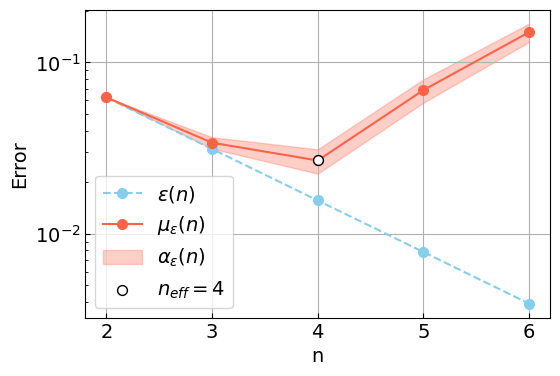

In [33]:
n_eff = compute_n_eff(data, display=True)